In [297]:
import pandas as pd
import math
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

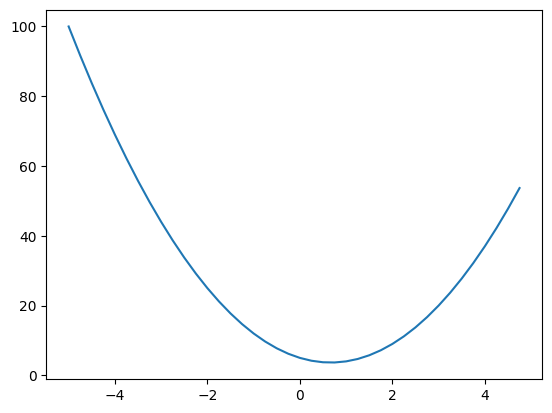

In [2]:
f = lambda x: 3*x**2 - 4*x + 5
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [3]:
h = 0.00001
x = 3.0
(f(x+h) - f(x))/h

14.00003000000538

In [387]:
class Value:
    def __init__(self, data, _children=(), _op = "", label="") -> None:
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __radd__(self, other): # other + self
        return self + other

    def __add__(self, other: "Value") -> "Value":
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out
    
    def __mul__(self, other: "Value") -> "Value":
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out
    
    def __rmul__(self, other: float) -> "Value":
        return self * Value(other)
    
    def tanh(self) -> "Value":
        t = math.tanh(self.data)
        out = Value(t, (self,), "tanh")
        
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        
        return out
    
    def __rmul__(self, other): # other * self
      return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __neg__(self): # -self
        return self * -1

    def __sub__(self, other): # self - other
        return self + (-other)

    def __radd__(self, other): # other + self
        return self + other

    def exp(self) -> "Value":
        t = math.exp(self.data)
        out = Value(t, (self,), "exp")
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        
        return out
    
    def __neg__(self) -> "Value":
        return self * -1
    
    def __sub__(self, other: "Value") -> "Value":
        return self + (-other)

    def __pow__(self, other: float) -> "Value":
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f"pow{other}")
        
        def _backward():
            self.grad += other * (self.data**(other-1)) * out.grad
        out._backward = _backward
        
        return out

    def backward(self):
    
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        #print(f'{list(reversed(topo))}')
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

    

In [388]:
a = Value(2.0,label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = (a*b); e.label = 'e'
d = e+c;d.label = 'd'
f = Value(-2.0, label='f')
L = d*f; L.label = 'L'
L

Value(data=-8.0)

In [389]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [390]:
L.backward()

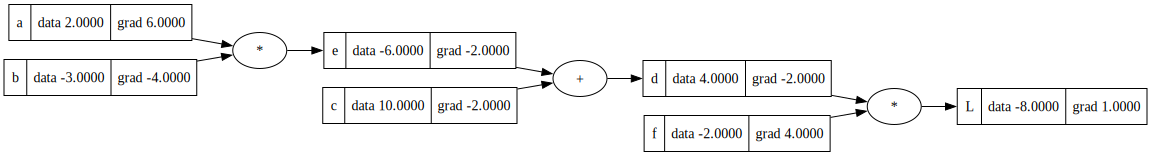

In [391]:
draw_dot(L)

In [392]:
# neurons
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
#o = n.tanh(); o.label = 'o'
#### implement tanh manually
e = (2*n).exp(); e.label = 'e'
#o = ( (n.exp() - (-n).exp()) / (n.exp() + (-n).exp()) ); o.label = 'o'
o = (e-1)/(e+1)
o.label = 'o'
#####
o.backward()

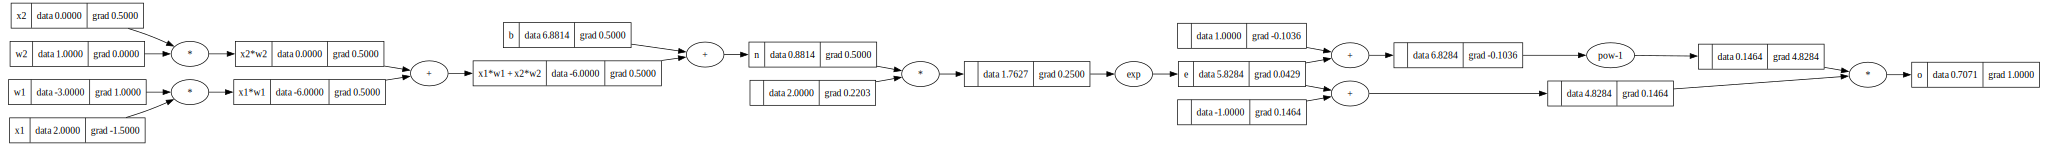

In [393]:
draw_dot(o)

In [394]:
# Now, let's use PyTorch
import torch

In [395]:
x1 = torch.tensor([2.0], dtype=torch.double, requires_grad=True)
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()



0.7071066904050358


In [396]:
print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [434]:
class Neuron:
    def __init__(self, nin: int):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
    
    def __call__(self, x):
        # w*x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out      

    def parameters(self):
        return self.w + [self.b]  
    
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.w + [neuron.b]]

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    
    def __call__(self, x):
        for idx,layer in enumerate(self.layers):
            print(f'{idx} {x.shape if isinstance(x, np.ndarray) else len(x)}')
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
        


In [435]:
x = [2., 3.]
#n = Neuron(2)
#n = Layer(2,3)
n = MLP(2, [3,4,4,1])
n(x)

0 2
1 3
2 4
3 4


Value(data=0.9360058901628399)

In [431]:
#draw_dot(n(x))

In [412]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [413]:
ypred = [n(x) for x in xs]
ypred

[Value(data=0.7916945653127212),
 Value(data=0.4450057170377422),
 Value(data=0.6823148630874288),
 Value(data=0.6889558407254665)]

0 4.64058089229407
1 3.625682325838794
2 2.753117100427416
3 2.9822728970944046
4 2.664229636981747
5 2.868981558544888
6 2.6931856851108256
7 2.7185580230653947
8 2.7434925939013937
9 2.472102959033305
10 2.727862909113484
11 2.2172573584595154
12 2.5957890060576836
13 2.117992418837331
14 2.6959506873831773
15 1.864108721368208
16 2.3968512946633442
17 2.5534002335581283
18 3.378310834923745
19 1.66815692164622
20 1.2159793640794976
21 1.3494186349195236
22 4.617384491014031
23 3.8431624071603774
24 1.1272054910066114
25 4.040539153543173
26 3.483304124841355
27 2.917444497292897
28 1.9621935156145602
29 1.757075135821654
30 1.0714589503040595
31 1.6421017724469187
32 4.395889115793125
33 0.6432197421190274
34 3.4174656609172613
35 2.730533032552525
36 0.8173517292550703
37 0.2683380667930122
38 0.18243729178017298
39 0.1668209004411519
40 0.12671711402343544
41 0.1334312146352432
42 0.08582881341074527
43 0.06843157117160499
44 0.0510576661544673
45 0.04668155732626943
46 0.04298634

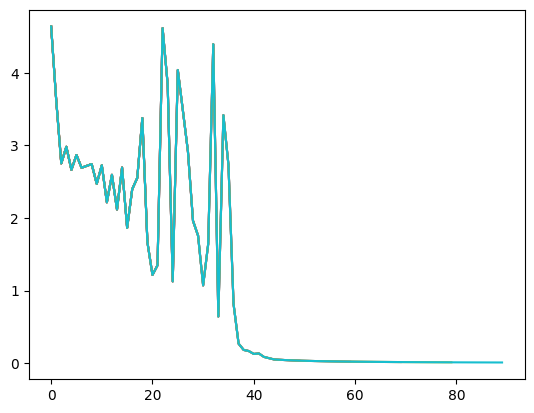

In [416]:
n_iter = 100
losses = []
for k in range(n_iter):
    y_pred = [n(x) for x in xs]
    loss = sum((y_pred - y) ** 2 for y_pred, y in zip(y_pred, ys))
    

    # calc backward
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    # update
    for p in n.parameters():
        p.data += -0.1 * p.grad
    
    print(k, loss.data)
    if k % 10 == 0:
        plt.plot(losses)
    losses.append(loss.data)
    

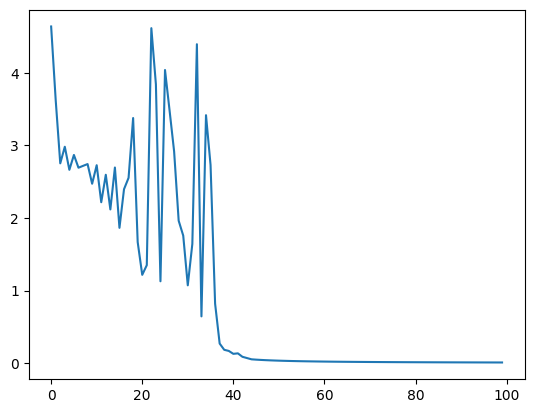

In [417]:
plt.plot(losses)

In [422]:
[(y, n(x)) for x,y in zip(xs, ys)]

[(1.0, Value(data=0.9826374089493642)),
 (-1.0, Value(data=-0.9748835479756133)),
 (-1.0, Value(data=-0.9406964617355474)),
 (1.0, Value(data=0.9454422019346633))]

In [428]:
n.layers[0].neurons[0].b

Value(data=2.317003280805021)